In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization

import matplotlib.pyplot as plt
print('Tensorflow version: ', tf.__version__)
print('GPU available: ', tf.config.list_physical_devices('GPU'))

Tensorflow version:  2.6.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data_dir = "BostonDS/datasets/initial_training"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 102004 files belonging to 14 classes.
Using 81604 files for training.
Found 102004 files belonging to 14 classes.
Using 20400 files for validation.
Found 19813 files belonging to 14 classes.


In [6]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Description: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Description: b'PL1160943,PLUMBING,Plumbing,Unit 1213 - Replace plumbing fixtures'
Label : 11 (Plumbing_Permit)
Description: b'ALT1071463,INTREN,Renovations - Interior NSC,roofing 24sq  siding33sq  front/back porch repairs  replace slider door  demo non structural wall  flooring and painting throughout the house  remodel kitchen and bathroom  update electrical and plumbing  new windows  update half bath  add new bathroom to second floor(eplan)'
Label : 10 (Long_Form_Alteration_Permit)
Description: b'ETS19362,ELECTRICAL,Electrical,Temp genny power for film production'
Label : 5 (Electrical_Temporary_Service)


In [7]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
model_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
model_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [8]:
bert_preprocess_model = hub.KerasLayer(model_preprocess)

In [9]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
bert_model = hub.KerasLayer(model_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {model_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76265013  0.99280924 -0.18567446  0.36696342  0.15207702  0.65472066
  0.96803373 -0.94872004  0.00212172 -0.98775613  0.06880213 -0.9763444 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28914532  0.34312406  0.33211374 ...  0.21299645  0.7093592
  -0.05769156]
 [-0.28731355  0.32045546 -0.23096198 ...  0.58478135 -0.21415293
   0.72672755]
 [-0.6613585   0.6888145  -0.87392294 ...  0.10913941 -0.26269644
   0.4778076 ]
 ...
 [-0.22536965 -0.2888788  -0.07084132 ...  0.47622922  0.83254266
   0.39969602]
 [-0.29792786 -0.27416703 -0.05504339 ...  0.48902804  1.0955799
   0.18092874]
 [-0.44318354  0.00971647  0.07226141 ...  0.17276692  1.1832001
   0.07846964]]


In [11]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(model_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(model_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(14, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

# Test the model maker
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.82804716 0.3016719  0.309959   0.41529283 0.20178011 0.39260787
  0.87124705 0.4348611  0.79524434 0.45323136 0.34849617 0.65508336
  0.42567655 0.16392133]], shape=(1, 14), dtype=float32)


In [12]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {model_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
2551/2551 [==============================] - 613s 239ms/step - loss: 0.2421 - sparse_top_k_categorical_accuracy: 0.9643 - val_loss: 3.6383e-05 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 2/5
2551/2551 [==============================] - 581s 228ms/step - loss: 3.9444e-04 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 1.6157e-05 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 3/5
2551/2551 [==============================] - 581s 228ms/step - loss: 3.1296e-04 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 1.0957e-05 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 4/5
2551/2551 [==============================] - 580s 228ms/step - loss: 2.4397e-04 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 1.7591e-05 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 5/5
2551/2551 [==============================] - 581s 228ms/step - loss: 1.1828e-04 - 

620/620 [==============================] - 76s 123ms/step - loss: 2.4498e-06 - sparse_top_k_categorical_accuracy: 1.0000
Loss: 2.4497599042661022e-06
Accuracy: 1.0
dict_keys(['loss', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_top_k_categorical_accuracy'])


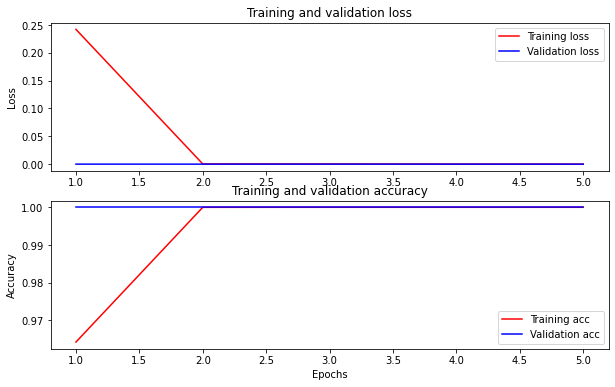

In [14]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_top_k_categorical_accuracy']
val_acc = history_dict['val_sparse_top_k_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [15]:
dataset_name = 'boston_DS'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./boston_DS_bert\assets


INFO:tensorflow:Assets written to: ./boston_DS_bert\assets


In [16]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [35]:
import numpy as np

def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'A1000569,INTEXT,Interior/Exterior Work,This work is to Amend Permit ALT347244. Eliminate construction of two party wall openings. Install new wheelchair lift.;;;;; E- Plans',  # this is the same sentence tried earlier
    'G421944,GAS,Gas,Replace leaking gas water heater.',
    'PL917318,PLUMBING,Plumbing,Installation of 2 Bathrooms and 1 Kitchen',
    'ELV765406,LVOLT,Low Voltage,installation of low voltage wireless burglar alarm system',
    'E1128739,ELECTRICAL,Electrical,Apt 54 on 5th floorWire bedroom/living room/bathroom and kitchen Combination of old work and new work Install new sub panel in unit'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results:')
max_ind = np.argmax(reloaded_results.numpy(), axis=1)
for idx in max_ind:
    print('\t',class_names[idx])


Results:
	 Amendment_to_a_Long_Form
	 Gas_Permit
	 Plumbing_Permit
	 Electrical_Low_Voltage
	 Electrical_Permit
